In [ ]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.utilities.rank_zero import rank_zero_only # NEW
from datetime import datetime

# Bacis libraries #
import os
from dotenv import load_dotenv
load_dotenv('/home/pk21271/keys/key.env')
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import BCEDecorrelatedLoss
from plotting import plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:
# Make output directory #
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"./model_training/AOTransformer_{current_time}"
os.makedirs(outdir, exist_ok=False)

## Specify dataset files to run over ##
path = "/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL{year}_ml_inputs/{dataset}.parquet"

datasets = [
    'ttH_HToInvisible_M125',
    'TTToSemiLeptonic',
]
years = ['2018']

files = [
    path.format(year=year, dataset=dataset)
    for dataset in datasets
    for year in years
]

## Data preprocessing ##
df = load_from_parquet(files)
df = remove_negative_events(df)
df["target"] = create_target_labels(df["dataset"])
apply_reweighting_per_class(df)
reweighting = torch.Tensor(df['weight_training'].values)
df["target"] = create_target_labels(df["dataset"])

X, y, pad_mask = awkward_to_inputs_parallel(df, n_processes=8, target_length=10)

event_level = get_event_level(df)
#split_masks = kfold_split(df, k=2)      # returns a list with a mask for each fold, so if only training one select it in line below
#split = split_masks[0]

## Create training datasets ##
train_X, val_X, train_y, val_y, train_weights, val_weights, train_mask, val_mask, train_event, val_event = train_test_split(
    X, 
    y, 
    reweighting, 
    pad_mask, 
    event_level, 
    test_size=0.2,  
    random_state=42,
)

train_dataset = TensorDataset(train_X, train_y, train_weights, train_mask, train_event)
valid_dataset = TensorDataset(val_X, val_y, val_weights, val_mask, val_event)

## Create loaders ##
batch_size = 1024

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True, 
)
valid_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size = 10000, # can use larger batches for the GPU 
    shuffle = False, 
    #num_workers = 20,
)
# NOTE : in a jupyter notebook it is not possible to use `num_workers` dues to multiprocessing issues.
# Use this notebook for testing and experimenting, but to benefit from multiprocessing batch loading, you will need the python scripts

2025-01-27 12:14:26,526 - INFO - Loading data from 2 parquet files...
2025-01-27 12:14:26,527 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ttH_HToInvisible_M125.parquet
2025-01-27 12:14:29,005 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ttH_HToInvisible_M125.parquet contains 266650 events
2025-01-27 12:14:29,124 - INFO - Filtered df contains 144551 events from regions [0]
2025-01-27 12:14:29,321 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTToSemiLeptonic.parquet
2025-01-27 12:14:50,895 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTToSemiLeptonic.parquet contains 2468208 events
2025-01-27 12:14:51,357 - INFO - Filtered df contains 437503 events from regions [0]
2025-01-27 12:14:53,963 - INFO - DataFrame loaded successfully with 582054 entries.
2025-01-27 12:14:54,208 - INFO - Negative events = 7515 [1.29%]...
2025-01-27 12:14:54,677 - INFO - Negativ

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$
- var 2 : $\phi$
- var 3 : mass
- var 4 : area


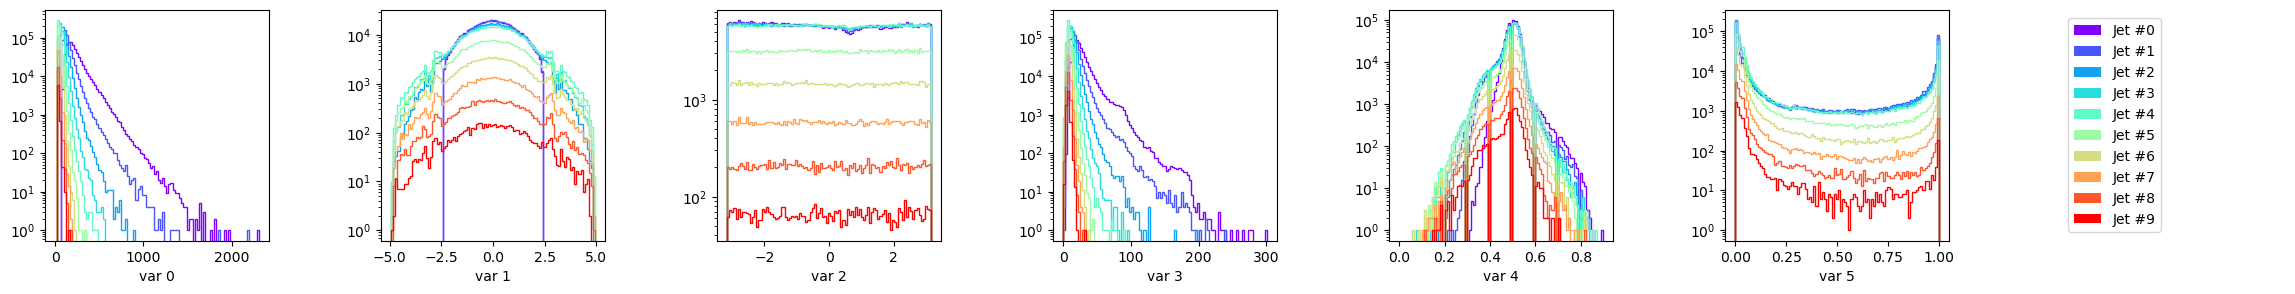

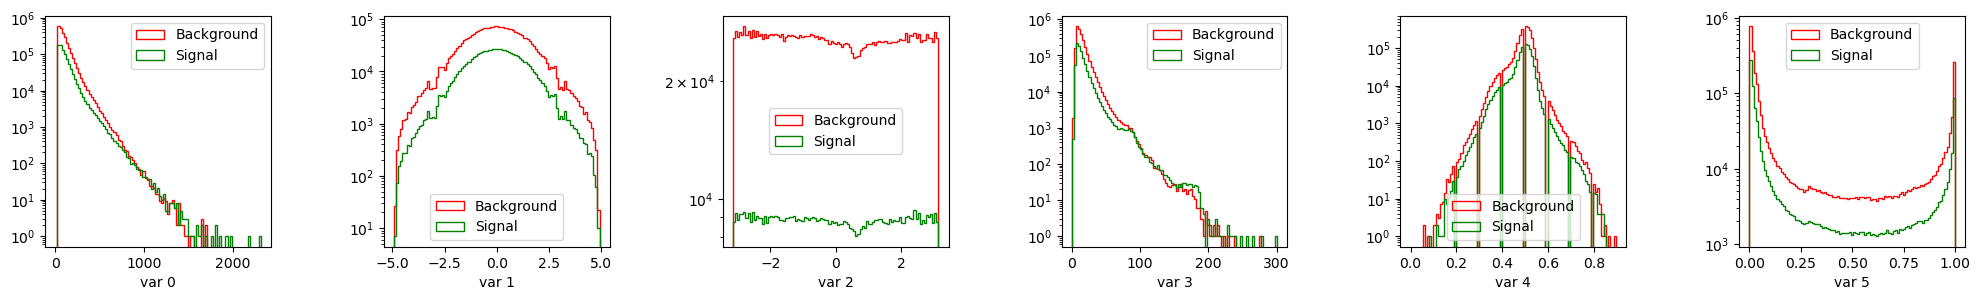

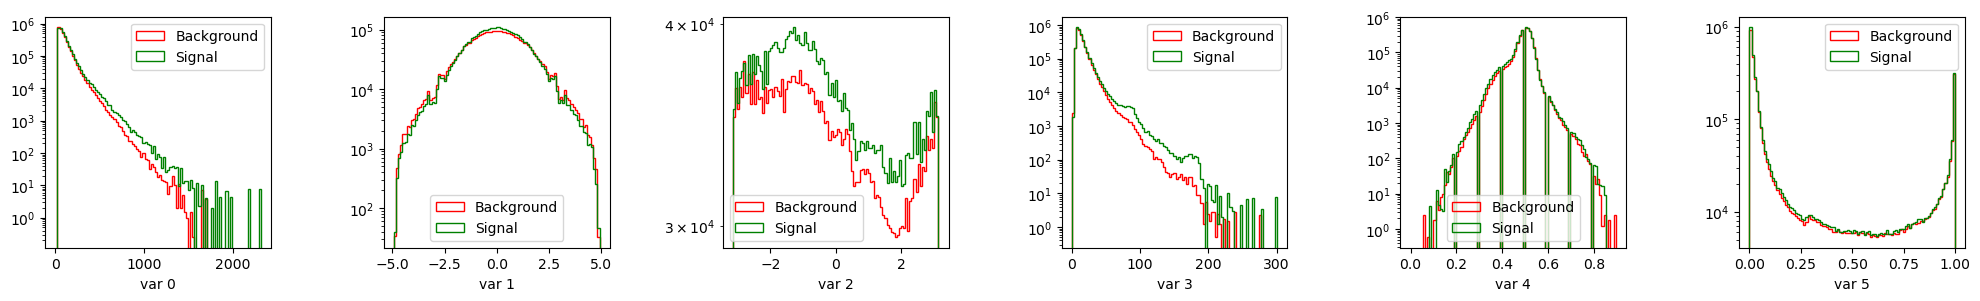

In [3]:
fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [ ]:
# Define model #
loss_function = BCEDecorrelatedLoss(lam = 0.1,weighted=True) # Create new one for multiclass, MDMM mechanism
# loss = BCE + lambda * decorrelated loss # WHAT IS LAMBDA
# lambda = 0 -> pure BCE

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)

model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance 
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim) 
    output_dim = 1,                  # Output dimension (1 : binary classification, >1 : multi classification) 
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor)
    encoder_layers = 3,              # Number of encoder layers (self attention on jets)
    class_layers = 3,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = 3,                  # Number of layers for DNN after the transformer
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.1,                  # Dropout rate
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-3): 4 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [5]:
##### Parameters #####
epochs = 100
lr = 1e-4

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.5, 
   patience = 5, #Was 10
   threshold = 0., 
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=8,          # Number of epochs with no improvement after which training will be stopped #Defacult was 30, changed to 8
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback(name='ROC'),
        ConfusionMatrixSubCallback(name='CM'),
    ]
)

## Logger ##
# logger = CometLogger(
#     api_key = os.environ.get("COMET_API_KEY"), 
#     project_name = "AnalysisObjectTransformer",
#     experiment_name = "Setup",
#     save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
#     offline = False  # Set to True for offline mode


## Logger ## (THIS IS THE NEW ONE WITH THE PATH SETUP)
logger = CometLogger(
    api_key = os.getenv("COMET_API_KEY"),
    project_name = "AnalysisObjectTransformer",
    experiment_name = "Setup",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    strategy = "ddp_notebook",
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = [0,1,2,3],  # Use only one GPU
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train,
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [
        checkpoint_callback, 
        early_stopping,
        log_bar,
        plots_callback,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)
trainer.save_checkpoint(f"{outdir}/model.pt")

Training   : Batch size = 1024 => 449 steps per epoch
Validation : Batch size = 10000 => 12 steps per epoch


CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:439: It is recommended to use `self.log('val/loss_bce', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:439: It is recommended to use `self.log('val/loss_disco', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:439: It is recommended to use `self.log('train/loss_bce', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:439: It is recommended to use `self.log('train/loss_disco', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:439: It is recommended to use `self.log('train/loss_tot', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
[rank: 0] Metric val/loss_tot improved. New best score: 1.344
[rank: 1] Metri

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.022 >= min_delta = 0.0. New best score: 1.322
[rank: 1] Metric val/loss_tot improved by 0.021 >= min_delta = 0.0. New best score: 1.308
[rank: 2] Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 1.326
[rank: 3] Metric val/loss_tot improved by 0.021 >= min_delta = 0.0. New best score: 1.311


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.302
[rank: 1] Metric val/loss_tot improved by 0.018 >= min_delta = 0.0. New best score: 1.290
[rank: 3] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 1.294
[rank: 2] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 1.308


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.283
[rank: 2] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.290
[rank: 3] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 1.276
[rank: 1] Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 1.270


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.011 >= min_delta = 0.0. New best score: 1.272
[rank: 2] Metric val/loss_tot improved by 0.014 >= min_delta = 0.0. New best score: 1.276
[rank: 3] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 1.265
[rank: 1] Metric val/loss_tot improved by 0.015 >= min_delta = 0.0. New best score: 1.255


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 1.260
[rank: 2] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 1.265
[rank: 1] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 1.243
[rank: 3] Metric val/loss_tot improved by 0.015 >= min_delta = 0.0. New best score: 1.250


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.258
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.265


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.015 >= min_delta = 0.0. New best score: 1.243
[rank: 1] Metric val/loss_tot improved by 0.014 >= min_delta = 0.0. New best score: 1.229
[rank: 3] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 1.237
[rank: 2] Metric val/loss_tot improved by 0.015 >= min_delta = 0.0. New best score: 1.249


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.015 >= min_delta = 0.0. New best score: 1.228
[rank: 1] Metric val/loss_tot improved by 0.018 >= min_delta = 0.0. New best score: 1.211
[rank: 3] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.218
[rank: 2] Metric val/loss_tot improved by 0.015 >= min_delta = 0.0. New best score: 1.234


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.209
[rank: 1] Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 1.191
[rank: 2] Metric val/loss_tot improved by 0.019 >= min_delta = 0.0. New best score: 1.215
[rank: 3] Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 1.198


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.206
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.190
[rank: 2] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.211
[rank: 3] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.196


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.199
[rank: 1] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 1.182
[rank: 2] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.206
[rank: 3] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 1.188


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.189
[rank: 1] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 1.169
[rank: 2] Metric val/loss_tot improved by 0.011 >= min_delta = 0.0. New best score: 1.195
[rank: 3] Metric val/loss_tot improved by 0.012 >= min_delta = 0.0. New best score: 1.176


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.015 >= min_delta = 0.0. New best score: 1.174
[rank: 2] Metric val/loss_tot improved by 0.014 >= min_delta = 0.0. New best score: 1.180
[rank: 1] Metric val/loss_tot improved by 0.011 >= min_delta = 0.0. New best score: 1.158
[rank: 3] Metric val/loss_tot improved by 0.015 >= min_delta = 0.0. New best score: 1.161


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 1.168
[rank: 1] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 1.150
[rank: 2] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.174
[rank: 3] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.155


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 1.160
[rank: 1] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.144
[rank: 2] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.168
[rank: 3] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 1.150


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.150
[rank: 1] Metric val/loss_tot improved by 0.009 >= min_delta = 0.0. New best score: 1.135
[rank: 2] Metric val/loss_tot improved by 0.009 >= min_delta = 0.0. New best score: 1.159
[rank: 3] Metric val/loss_tot improved by 0.011 >= min_delta = 0.0. New best score: 1.139


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.146
[rank: 2] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.157
[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.132


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.136
[rank: 1] Metric val/loss_tot improved by 0.011 >= min_delta = 0.0. New best score: 1.122
[rank: 2] Metric val/loss_tot improved by 0.011 >= min_delta = 0.0. New best score: 1.146
[rank: 3] Metric val/loss_tot improved by 0.014 >= min_delta = 0.0. New best score: 1.125


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.135
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.146
[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.120
[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.124


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.133
[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.123
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.146
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.118


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.130
[rank: 2] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.140
[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.116
[rank: 3] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.119


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.123
[rank: 1] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.111
[rank: 2] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.136
[rank: 3] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.117


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.123
[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.109
[rank: 2] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.133
[rank: 3] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.111


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.122
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.108
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.133
[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.110


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.121
[rank: 2] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.129


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.109


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 1] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.104


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.103
[rank: 3] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.106
[rank: 2] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.127


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.111


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 1] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.101
[rank: 2] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.125
[rank: 3] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.102


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.109
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.099
[rank: 2] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.122
[rank: 3] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.098


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.106
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.098


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 2] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.116
[rank: 3] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.096


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 3] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.092


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 1.096


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.105


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 2] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.113


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.105
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.096
[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.091


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.104
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.113


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 3] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.091


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 1] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.096


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.094
[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.090


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 1] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.094
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.113


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.104
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.113
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 1.094


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 3] Monitored metric val/loss_tot did not improve in the last 10 records. Best score: 1.090. Signaling Trainer to stop.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Setup
COMET INFO:     url                   : https://www.comet.com/inigostibbe/analysisobjecttransformer/6d8238686d3d45959d33eb40b6efaa7b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train/loss_bce [87]   : (1.1060094833374023, 1.3572046756744385)
COMET INFO:     train/loss_disco [87] : (0.025978710502386093, 0.1020452156662941)
COMET INFO:     train/loss_tot [87]   : (1.1152253150939941, 1.359802007675171)
COMET INFO:     val/loss_bce [87]     : (1.0920122861862183, 1.338987946510315)
COMET INFO:     val/loss_di

In [8]:
## Testing model performance on validation set ##
single_gpu_trainer = L.Trainer(accelerator="gpu", devices=1)
preds = single_gpu_trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)

inputs, labels, weights, mask, event = valid_dataset.tensors

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /users/pk21271/msciproject/bristol-tth-transformer-msc_project/bristol-tth-transformer-msc_project/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]
/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [35]:
labels.shape, preds.shape, weights.shape,
labels

(torch.Size([114908, 1]), torch.Size([114908, 1]), torch.Size([114908]))

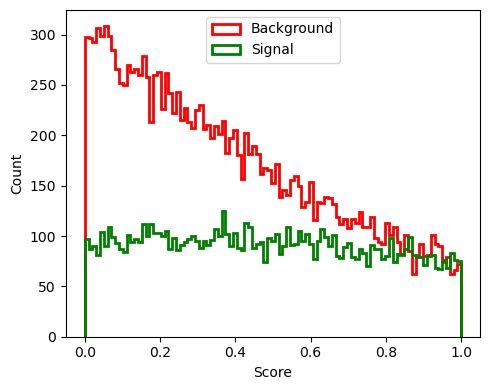

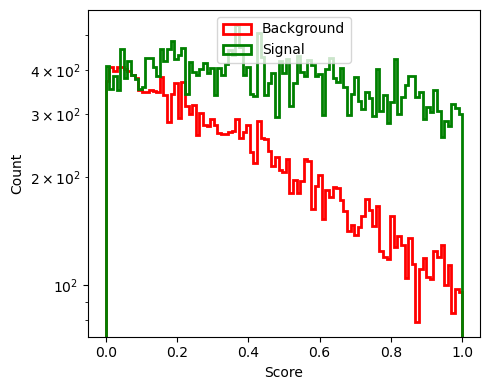

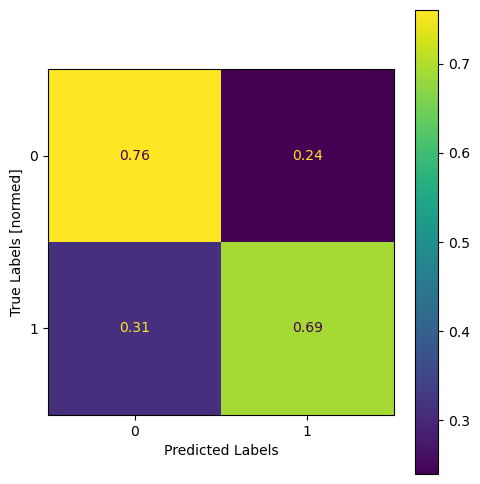

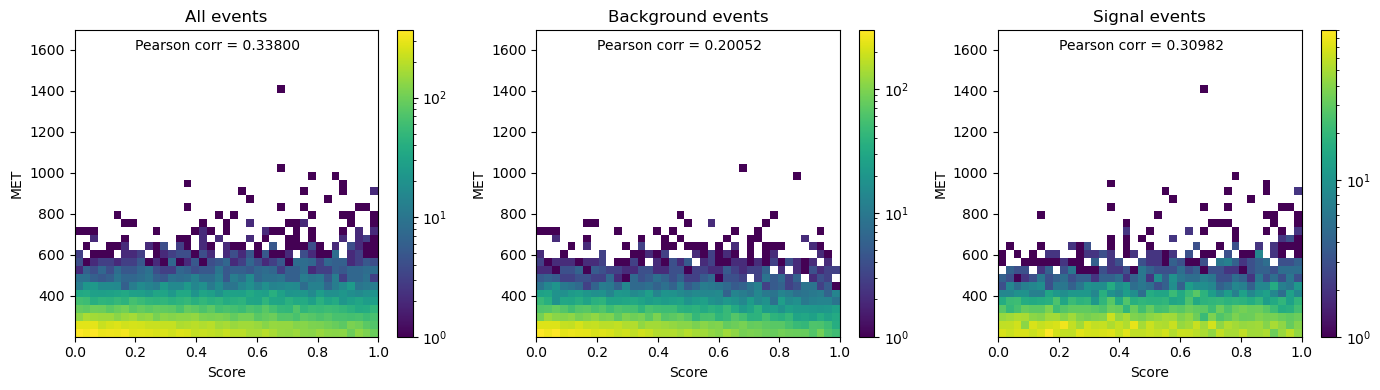

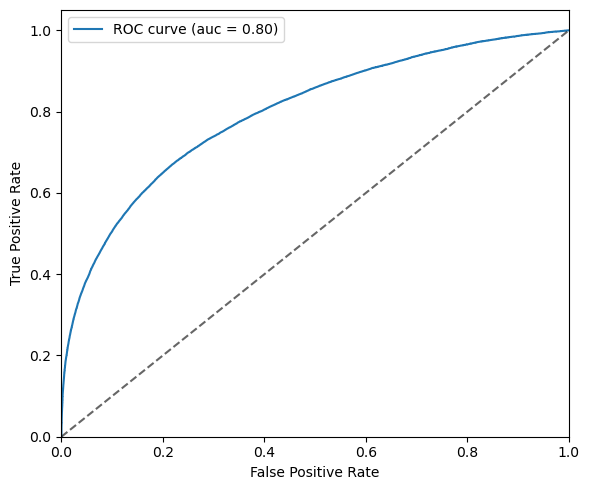

In [11]:
fig = plot_score(labels,preds,outdir=outdir,bins=100,log=False)
fig = plot_score(labels,preds,weights=weights,outdir=outdir,bins=100,log=True)
fig = plot_confusion_matrix(labels, torch.sigmoid(preds), outdir=outdir,show=True)
fig = plot_correlation(labels,preds,event,outdir=outdir,log=True,bins=40)
fig = plot_roc(labels, preds, outdir=outdir,show=True)

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_threshold_with_plot(preds, labels, weights):
    # Convert tensors to NumPy arrays
    preds = torch.sigmoid(preds.flatten()).cpu().numpy()  # Ensure predictions are in the range [0, 1]
    labels = labels.flatten().cpu().numpy()
    weights = weights.flatten().cpu().numpy()

    thresholds = np.linspace(0, 1, 1000)  # Generate thresholds between 0 and 1
    best_threshold = 0
    best_z = 0
    z_scores = []  # Store Z-scores for plotting

    for threshold in thresholds:
        # Apply threshold
        predicted_signal = preds >= threshold

        # Calculate S and B
        S = np.sum(weights[(predicted_signal) & (labels == 1)])  # Weighted signal
        B = np.sum(weights[(predicted_signal) & (labels == 0)])  # Weighted background

        # Avoid division by zero
        if B > 0:
            Z = S / np.sqrt(B)
        else:
            Z = 0

        z_scores.append(Z)  # Save Z-score for plotting

        # Track the best threshold
        if Z > best_z:
            best_z = Z
            best_threshold = threshold

    # Plot Z-scores vs thresholds
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, z_scores, label="Z-Score")
    plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("Z-Score")
    plt.title("Z-Score vs Threshold")
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold, best_z


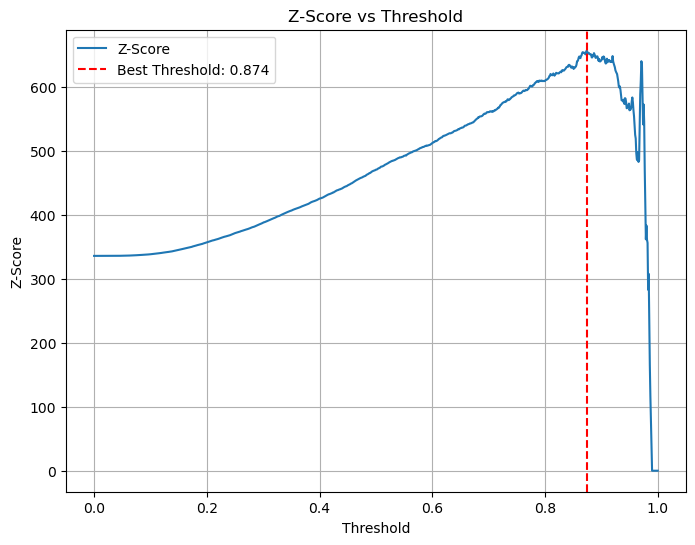

Optimal Threshold: 0.8738738738738738
Maximum Z-Score: 657.282470703125


In [43]:
# Find the optimal threshold and plot
best_threshold, best_z = find_optimal_threshold_with_plot(preds, labels, weights)
print(f"Optimal Threshold: {best_threshold}")
print(f"Maximum Z-Score: {best_z}")

In [71]:
# Checking weights 

inputs, labels, weights, mask, event = valid_dataset.tensors
print(len(labels[labels == 0]))
print(len(labels[labels == 1]))
# print()
# print(np.sum(weights[labels.flatten() == 0]))
# print(labels.shape, weights.shape)
a = np.array(labels.flatten())
a

86793
28115


array([0., 0., 1., ..., 0., 0., 1.], dtype=float32)

In [76]:
weights2 = np.array(weights.flatten())
print(np.sum(weights2[a == 0]))
print(np.sum(weights2[a == 1]))

115448.586
114234.56
